In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plot_tools import plot_groups, plot_input_image
%matplotlib inline
np.random.seed(985619)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import h5py
import os
import os.path

data_dir = os.environ.get('BRAINSTORM_DATA_DIR', '.')

# MNIST + Shape

Binary images containing a thresholded MNIST digit and one random shape each. Introduced in [1] to investigate binding in deep networks.

In [3]:
square = np.array(
    [[1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1]])

triangle = np.array(
    [[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
     [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
     [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

shapes = [square, triangle, triangle[::-1, :].copy()]

In [4]:
# Load the MNIST Dataset as prepared by the brainstorm data script
# You will need to run brainstorm/data/create_mnist.py first
with h5py.File(os.path.join(data_dir, 'MNIST.hdf5'), 'r') as f:
    mnist_digits = f['normalized_full/training/default'][0, :]
    targets = f['normalized_full/training/targets'][:]
    mnist_digits_test = f['normalized_full/test/default'][0, :]
    targets_test = f['normalized_full/test/targets'][:]

In [5]:
def generate_mnist_shape_img(digit_nr, nr_shapes=1, test=False):
    if digit_nr is None:
        img = np.zeros((28, 28), dtype=np.float)
    elif not test:
        img = (mnist_digits[digit_nr].reshape(28, 28) > 0.5).astype(np.float)
    else:
        img = (mnist_digits_test[digit_nr].reshape(28, 28) > 0.5).astype(np.float)
    grp = (img > 0.5).astype(np.float)
    mask = grp.copy()
    k = 2
    
    for i in range(nr_shapes):
        shape = shapes[np.random.randint(0, len(shapes))]
        sy, sx = shape.shape
        x = np.random.randint(0, 28-sx+1)
        y = np.random.randint(0, 28-sy+1)
        region = (slice(y,y+sy), slice(x,x+sx))
        img[region][shape != 0] = 1
        mask[region][shape != 0] += 1
        grp[region][shape != 0] = k      
        k += 1
        
    grp[mask > 1] = 0
    return img, grp
    

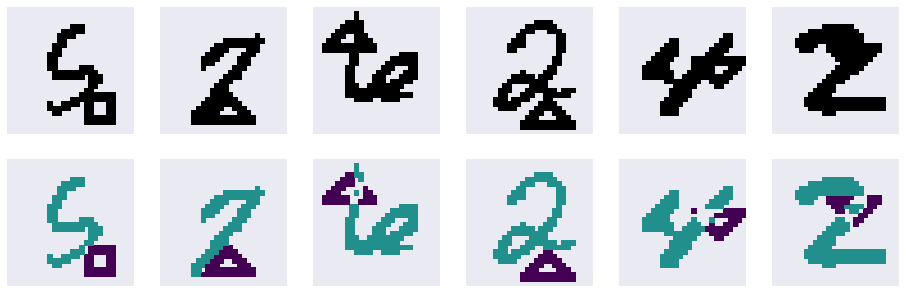

In [6]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(16, 5))
for ax in axes.T:
    digit_nr = np.random.randint(0, 60000)
    img, grp = generate_mnist_shape_img(digit_nr, 1)
    plot_input_image(img, ax[0])
    plot_groups(grp, ax[1])

# Save as HDF5 Dataset

In [7]:
np.random.seed(985619)
nr_shapes = 1
nr_training_examples = 60000
nr_test_examples = 10000
nr_single_examples = 10000


data = np.zeros((1, nr_training_examples, 28, 28, 1), dtype=np.float32)
grps = np.zeros_like(data)
for i in range(nr_training_examples):
    data[0, i, :, :, 0], grps[0, i, :, :, 0] = generate_mnist_shape_img(i, nr_shapes)
    
data_test = np.zeros((1, nr_test_examples, 28, 28, 1), dtype=np.float32)
grps_test = np.zeros_like(data_test)
for i in range(nr_test_examples):
    data_test[0, i, :, :, 0], grps_test[0, i, :, :, 0] = generate_mnist_shape_img(i, nr_shapes, test=True)
    

data_single = np.zeros((1, nr_single_examples, 28, 28, 1), dtype=np.float32)
grps_single = np.zeros_like(data_single)
for i in range(nr_single_examples // 2):
    digit_nr = np.random.randint(0, 60000)
    data_single[0, i, :, :, 0], grps_single[0, i, :, :, 0] = generate_mnist_shape_img(digit_nr, 0)
for i in range(nr_single_examples // 2, nr_single_examples):
    data_single[0, i, :, :, 0], grps_single[0, i, :, :, 0] = generate_mnist_shape_img(None, 1)

shuffel_idx = np.arange(nr_single_examples)
np.random.shuffle(shuffel_idx)
data_single = data_single[:, shuffel_idx]
grps_single = grps_single[:, shuffel_idx]

In [8]:
with h5py.File(os.path.join(data_dir, 'mnist_shape.h5'), 'w') as f:
    single = f.create_group('train_single')
    single.create_dataset('default', data=data_single, compression='gzip', chunks=(1, 100, 28, 28, 1))
    single.create_dataset('groups', data=grps_single, compression='gzip', chunks=(1, 100, 28, 28, 1))
    
    train = f.create_group('train_multi')
    train.create_dataset('default', data=data, compression='gzip', chunks=(1, 100, 28, 28, 1))
    train.create_dataset('groups', data=grps, compression='gzip', chunks=(1, 100, 28, 28, 1))
    train.create_dataset('targets', data=targets, compression='gzip', chunks=(1, 100, 1))
    
    test = f.create_group('test')
    test.create_dataset('default', data=data_test, compression='gzip', chunks=(1, 100, 28, 28, 1))
    test.create_dataset('groups', data=grps_test, compression='gzip', chunks=(1, 100, 28, 28, 1))
    test.create_dataset('targets', data=targets_test, compression='gzip', chunks=(1, 100, 1))

# References
[1] David P. Reichert and Thomas Serre, [Neuronal Synchrony in Complex-Valued Deep Networks](http://arxiv.org/abs/1312.6115), ICLR 2014

